In [3]:
import matplotlib.pyplot as plt
import numpy as np
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
from quantum_logical.interaction import ConversionGainInteraction
from quantum_logical.operators import define_observables
from quantum_logical.trotter import TrotterGroup
from qutip import Qobj, basis, expect, tensor
from scipy.linalg import fractional_matrix_power

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
from quantum_logical.qudit_op import QutritUnitary
from qiskit.circuit.parameter import Parameter

from qiskit.transpiler import InstructionDurations
from qiskit import transpile
from qutip import qeye

from qiskit.converters import circuit_to_dag

In [4]:
N = 2  # Number of qubits
dim = 3  # hilbert space dim

# Assuming all qubits have the same T1 and T2
T1 = 1
T2 = 1
trotter_step_size = 0.1

encoded_state = basis(dim, 0) + basis(dim, 2)
encoded_state /= encoded_state.norm()

# tensor with ancilla in |g>
initial_state = tensor(encoded_state, basis(dim, 0))
initial_state = initial_state * initial_state.dag()
initial_state /= initial_state.norm()
initial_state

observables, observable_labels = define_observables(N, dim, exclude_symmetric=False)

In [5]:
gc, gg = np.pi / 2, 0
trotter_dt = 0.05
duration = 1.0
H = ConversionGainInteraction(gc, gg, transmon_levels=dim)
iswap = H.construct_U(t=duration)
iswap = Qobj(iswap, dims=[[9], [9]])
iswap = tensor(iswap)
iswap

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

In [53]:
from qiskit.providers.aer.library import SaveDensityMatrix

num_qubits = 2
qc = QuantumCircuit(num_qubits)
qiskit_iswap = Operator(iswap.full(), input_dims=[3, 3], output_dims=[3, 3])
qutrit_iswap = QutritUnitary(qiskit_iswap, label="iswap_ge")
# qc.delay(Parameter("t"), 0)

# initial_state is some mixed two-qutrit state
initial_state = np.kron(np.eye(3), np.eye(3))

qc.set_density_matrix(initial_state)
qc.x(0)
qc.append(qutrit_iswap, [0, 1])
qc.append(SaveDensityMatrix(num_qubits, label="final_rho"), range(num_qubits))
qc.draw()

ExtensionError: 'The size of the density matrix for the set state instruction must be equal to the number of qubits in the circuit (state.num_qubits (None) != QuantumCircuit.num_qubits (2)).'

In [52]:
from qiskit import Aer

# Transpile for simulator
sim_density = Aer.get_backend("aer_simulator_density_matrix")
circ = transpile(qc, sim_density)

job_density = sim_density.run(circ, shots=1000)
counts_density = job_density.result()
counts_density.data()["final_rho"].to_dict()

{'01|00': -1j}

In [28]:
from qiskit_aer.backends import QasmSimulator
from qiskit import Aer

simulator = QasmSimulator(method="density_matrix")
circ = transpile(qc, simulator)
result = simulator.run(circ)
result

In [25]:
# Run and get counts
sim_density = Aer.get_backend("aer_simulator_density_matrix")
job_density = sim_density.run(circ, shots=1000)
counts_density = job_density.result().get_counts(0)

QiskitError: 'No counts for experiment "0"'

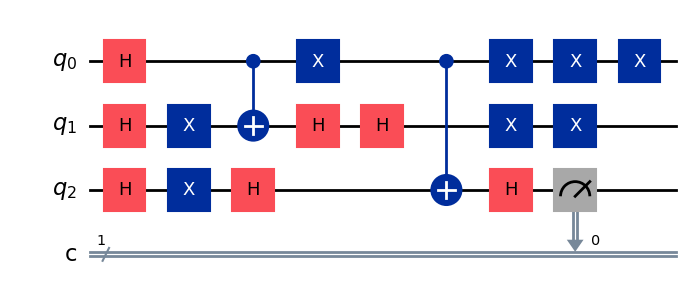

In [81]:
qc = QuantumCircuit(3, 1)
qc.h(0)
qc.h(1)
qc.h(2)
qc.x(2)
qc.x(1)
qc.cx(0, 1)
qc.x(0)
qc.h(1)
qc.h(2)
qc.h(1)
qc.x(1)
qc.cx(0, 2)
qc.x(0)
qc.h(2)
qc.x(0)
qc.x(1)
qc.x(0)
qc.measure(2, 0)
qc.draw("mpl", style="iqp")

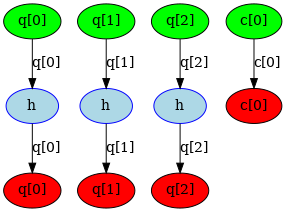

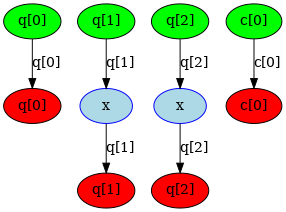

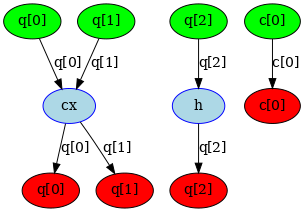

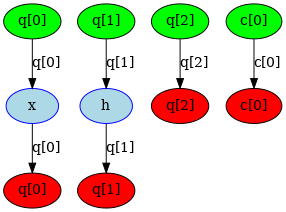

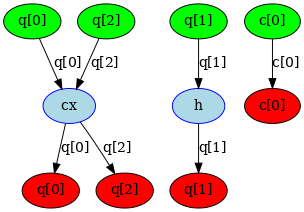

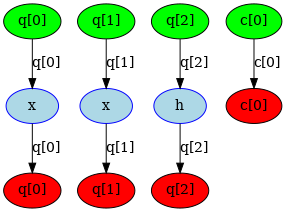

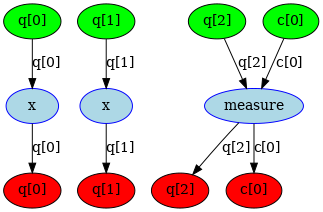

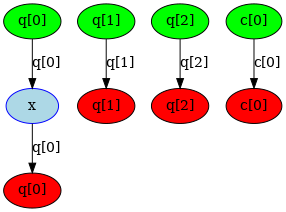

In [82]:
dag = circuit_to_dag(qc)
for layer in dag.layers():
    display(layer["graph"].draw())

In [83]:
instruction_durations = []
instruction_durations.append(("cx", (0, 1), 1.0))
instruction_durations.append(("cx", (0, 2), 1.0))
instruction_durations.append(("cx", (1, 2), 1.0))
instruction_durations.append(("x", (0,), 1))
instruction_durations.append(("x", (1,), 1))
instruction_durations.append(("x", (2,), 1))
instruction_durations.append(("h", (0,), 5))
instruction_durations.append(("h", (1,), 5))
instruction_durations.append(("h", (2,), 5))
instruction_durations.append(("measure", (0,), 10))
instruction_durations.append(("measure", (1,), 10))
instruction_durations.append(("measure", (2,), 10))
instruction_durations = InstructionDurations(instruction_durations)

In [93]:
from qiskit.providers.fake_provider import FakeManilaV2

backend = FakeManilaV2()

In [97]:
from qiskit import schedule

qc = QuantumCircuit(2, 2)
qc.h(1)
qc.cx(1, 0)
qc.measure([0, 1], [0, 1])
qc = transpile(qc, backend)
pulse_schedule = schedule(qc, backend)

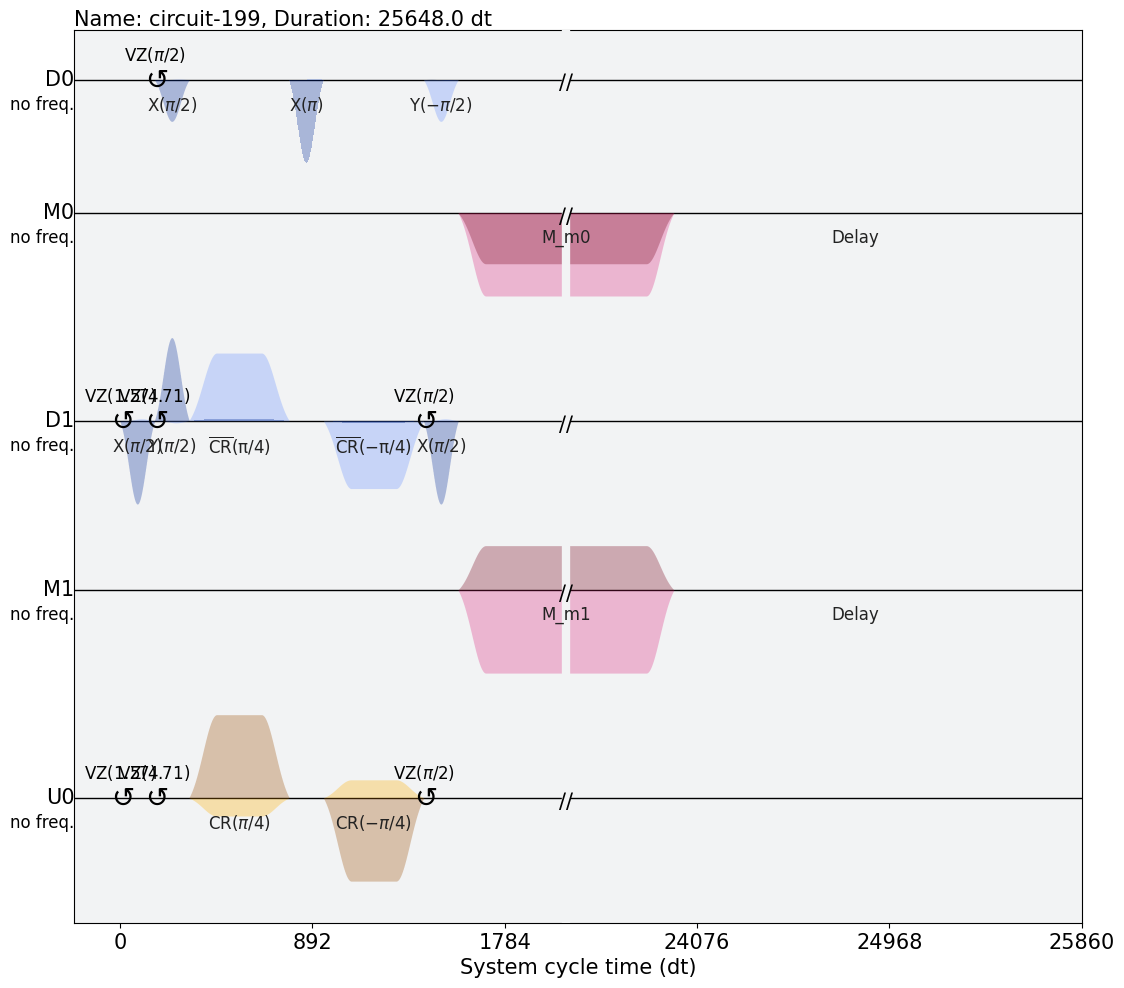

In [98]:
pulse_schedule.draw()

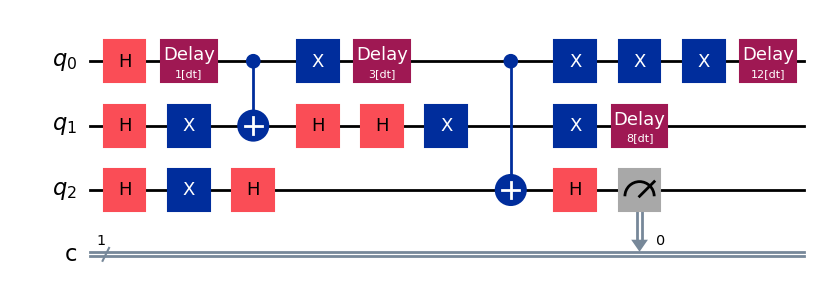

In [84]:
output_qc = transpile(
    qc,
    instruction_durations=instruction_durations,
    basis_gates=["x", "h", "cx"],
    scheduling_method="asap",
)
output_qc.draw("mpl", style="iqp")

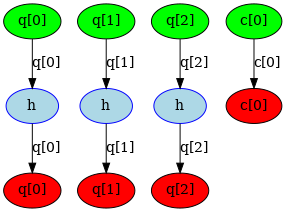

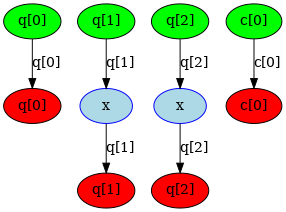

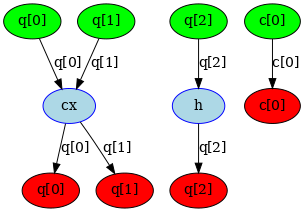

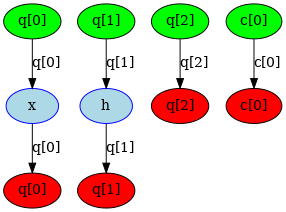

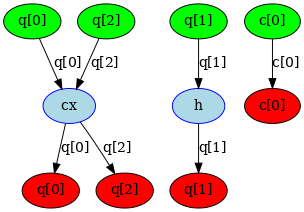

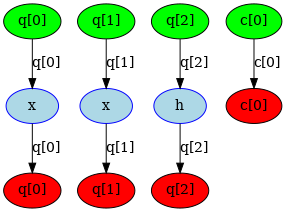

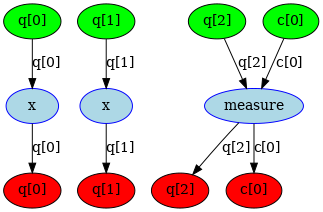

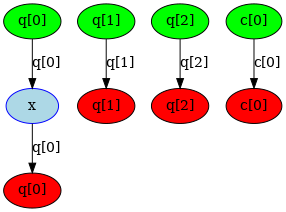

In [85]:
dag = circuit_to_dag(qc)
for layer in dag.layers():
    display(layer["graph"].draw())

In [103]:
from qiskit import QuantumCircuit
from qiskit.providers.basicaer import QasmSimulatorPy

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.h(1)
qc.measure(0, 0)
# classical-conditioned gate
qc.x(1).c_if(0, 1)
qc.measure(1, 1)
qc.draw("mpl")

backend = QasmSimulatorPy()
job = backend.run(qc)
result = job.result()
result.get_counts()

/home/evm9/quantum_logical/.venv/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


{'11': 260, '10': 266, '00': 249, '01': 249}

In [86]:
class FooSimulator:
    def __init__(
        self, noise_model: TrotterGroup, instruction_durations: InstructionDurations
    ):
        self.noise_model = noise_model
        self.instruction_durations = instruction_durations

    def _schedule_layers(self, qc):
        # run scheduler
        scheduled_qc = transpile(
            qc,
            instruction_durations=self.instruction_durations,
            basis_gates=["x", "h"],
            scheduling_method="asap",
        )

        # separate circuit into layers
        # XXX: there is probably a better way to do this :)
        dag = circuit_to_dag(scheduled_qc)
        layers = []
        for layer in dag.layers():
            layer_dag = layer["graph"]

            # layer duration is max duration of all instructions in layer
            # NOTE: layer_dag has a duration attribute, but it is total qc duration
            layer_duration = max(
                [
                    self.instruction_durations.get(
                        i.op, [scheduled_qc.find_bit(j)[0] for j in i.qargs]
                    )
                    for i in layer_dag.op_nodes()
                ]
            )

            layers.append((layer_dag, layer_duration))

        return layers

    def run(self, qc):
        num_qubits = qc.num_qubits

        # layers = [(layer_dag, duration), ...]
        layers = self._schedule_layers(qc)

        # assume initial state is |0>^N
        state = basis(2**num_qubits, 0)
        rho = state * state.dag()

        for layer_dag, duration in layers:
            # construct layer-wise unitary
            # tensor product over all indices,
            # either identity or the gate present at that index
            layer_unitary = qeye(2**num_qubits)

            for i in range(num_qubits):
                # get gate at this index
                gate = layer_dag.op_nodes(qargs=[i]).pop().op

                # if no gate at this index, identity
                if gate.name == "id":
                    layer_unitary = tensor(layer_unitary, qeye(2))
                else:
                    # otherwise, append gate to layer unitary
                    layer_unitary = tensor(layer_unitary, gate.to_matrix())

            # apply noisy layer
            rho = self.noise_model.apply(rho, duration, discrete_unitary=layer_unitary)

In [87]:
# TODO: read these docs
# from qiskit.scheduler.schedule_circuit import schedule_circuit
# from qiskit.scheduler import ScheduleConfig

In [88]:
# from qiskit.converters import circuit_to_dag

# dag = circuit_to_dag(output_qc)
# for layer in dag.layers():
#     display(layer["graph"].draw())

In [89]:
amp_damp_channel = AmplitudeDamping(T1, num_qubits=N, hilbert_space_dim=dim)
phase_damp_channel = PhaseDamping(T1, T2, num_qubits=N, hilbert_space_dim=dim)
trotter = TrotterGroup(
    continuous_operators=[amp_damp_channel, phase_damp_channel],
    trotter_dt=trotter_step_size,
)


def propagate_state(rho, duration, unitary=None):
    return trotter.apply(rho, duration, discrete_unitary=unitary)

In [90]:
FooSimulator(noise_model=trotter, instruction_durations=instruction_durations).run(qc)

TranspilerError: "Unable to translate the operations in the circuit: ['h', 'x', 'cx', 'measure'] to the backend's (or manually specified) target basis: ['snapshot', 'reset', 'h', 'x', 'measure', 'barrier', 'delay']. This likely means the target basis is not universal or there are additional equivalence rules needed in the EquivalenceLibrary being used. For more details on this error see: https://qiskit.org/documentation/stubs/qiskit.transpiler.passes.BasisTranslator.html#translation_errors"

In [ ]:
from qiskit.converters import circuit_to_dag

dag = circuit_to_dag(output_qc)
for layer in dag.layers():
    layer

In [ ]:
output_qc.qubit_duration(1)

7

In [ ]:
def projective_measurement(state, outcome):
    """
    Perform a projective (can be partial) measurement on the ancilla qubit.

    Args:
        state (Qobj): The density matrix of the quantum state.
        outcome (str): The measurement outcome ('g' or 'e').

    Returns:
        Qobj: The updated state after the measurement.
    """
    # Define projectors for |g> and |e>
    P_g = tensor(
        [Qobj(np.identity(dim)) for _ in range(N - 1)]
        + [basis(dim, 0) * basis(dim, 0).dag()]
    )
    P_e = tensor(
        [Qobj(np.identity(dim)) for _ in range(N - 1)]
        + [basis(dim, 1) * basis(dim, 1).dag()]
    )

    # Update dims
    P_g.dims = state.dims
    P_e.dims = state.dims

    # Apply the appropriate projector
    if outcome == "g":
        updated_state = P_g * state * P_g.dag()
    elif outcome == "e":
        updated_state = P_e * state * P_e.dag()
    else:
        raise ValueError("Invalid outcome. Choose 'g' or 'e'.")

    # Renormalize the state
    return updated_state / updated_state.tr()

In [ ]:
def execute_experiment_schedule(initial_state, schedule, time_step):
    """
    Execute a quantum experiment according to a specified schedule.

    Args:
        initial_state (Qobj): The initial quantum state (density matrix) of the system.
        schedule (list of dicts): A list where each item represents a stage in the experiment.
                                  Each stage is a dictionary containing 'type' (e.g., 'idle',
                                  'gate', 'meas'), 'duration' for propagation
                                  and unitary stages, 'gate' for the unitary to be applied, and
                                  'outcome' for the measurement stage.
        time_step (float): The time step size for sampling the state evolution.

    Returns:
        tuple: A tuple containing:
               - states (list of Qobj): The quantum states at each time step.
               - time_points (list of floats): The corresponding time points for each state.
               - stage_end_times (list of floats): The end times of each stage.
    """

    # Ensure all stage durations are positive
    for stage in schedule:
        if stage["duration"] <= 0:
            raise ValueError("All stage durations must be greater than zero.")

    current_state = initial_state
    states = [initial_state]
    time_points = [0]
    stage_end_times = []  # Store the end times of each stage

    for stage in schedule:
        stage_duration = stage["duration"]
        stage_end_time = time_points[-1] + stage_duration
        stage_end_times.append(stage_end_time)

        if stage["type"] in ["idle", "gate"]:
            steps = int(stage_duration / time_step)
            for step in range(1, steps + 1):
                current_duration = step * time_step
                unitary = None

                if stage["type"] == "gate":
                    # Apply the unitary operator fractionally over the stage duration
                    fractional_duration = current_duration / stage_duration
                    unitary = fractional_matrix_power(
                        stage["unitary"], fractional_duration
                    )

                # Propagate the state for the current duration
                state_at_step = propagate_state(
                    initial_state, current_duration, unitary
                )
                states.append(state_at_step)
                time_points.append(time_points[-1] + time_step)

            # Update the current state at the end of the stage
            current_state = state_at_step

        elif stage["type"] == "meas":
            # Measurement is treated as a single step at the end of its duration
            time_points.append(stage_end_time)  # Add end time of measurement
            current_state = projective_measurement(current_state, stage["outcome"])
            states.append(current_state)

        # Prepare the initial state for the next stage
        initial_state = current_state

    return states, time_points, stage_end_times

In [ ]:
def plot_observables_vs_time(
    time_points, states, observables, stage_end_times, schedule
):
    plt.figure(figsize=(10, 6))
    relevant_observables = {}  # Store observables with non-zero values

    for label, obs in observables.items():
        exp_values = [expect(Qobj(obs, dims=state.dims), state) for state in states]
        if not all(value == 0 for value in exp_values):
            relevant_observables[label] = exp_values
            plt.plot(time_points, exp_values, label=label)

    # Add vertical lines and annotations for stage transitions
    for i, end_time in enumerate(stage_end_times):
        if i > 0:
            start_time = stage_end_times[i - 1]
        else:
            start_time = 0

        plt.axvline(x=end_time, color="gray", linestyle="--")
        stage_center = (start_time + end_time) / 2

        # Annotate each stage
        if i < len(schedule):
            stage_label = schedule[i]["type"]
            if stage_label == "gate":
                stage_label = "iSWAP"  # Customize as needed

            plt.text(
                stage_center,
                plt.gca().get_ylim()[1],
                stage_label,
                ha="center",
                color="gray",
            )

    plt.xlabel("Time")
    plt.ylabel("Expectation Value")
    plt.title("Observable Expectation Values Over Time", pad=10)
    plt.legend()
    plt.grid(True)
    plt.show()

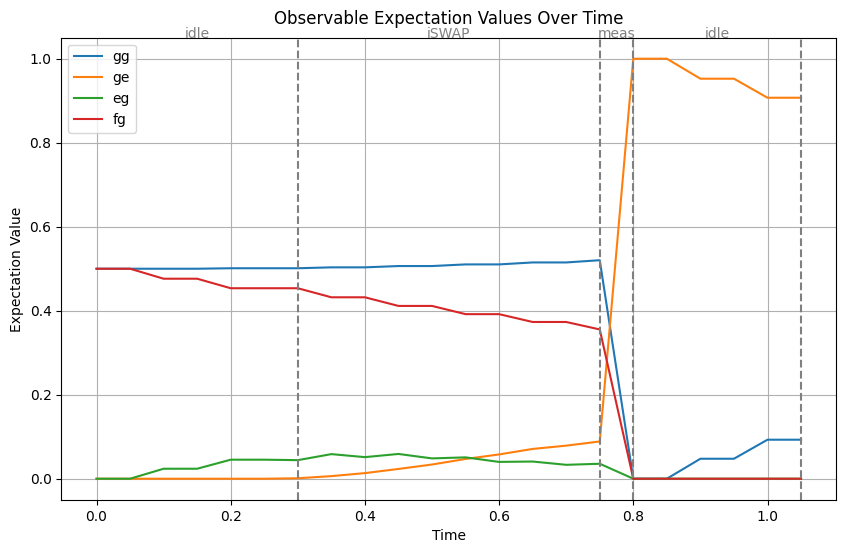

In [ ]:
# Define the schedule for the experiment
experiment_schedule = [
    {"type": "idle", "duration": 0.3, "unitary": None},
    {"type": "gate", "duration": 0.5, "unitary": iswap},
    # {"type": "idle", "duration": 0.1, "unitary": None},
    {"type": "meas", "duration": 0.05, "outcome": "e"},
    {"type": "idle", "duration": 0.25, "unitary": None},
]

# Define a small time step for more granular sampling
time_step = 0.05

# Execute the experiment with intermediate sampling
experiment_states, time_points, stage_end_times = execute_experiment_schedule(
    initial_state, experiment_schedule, time_step
)

# Plotting the results
plot_observables_vs_time(
    time_points, experiment_states, observables, stage_end_times, experiment_schedule
)